# Importando todo

## Librerias

In [1]:
# For Data
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from scipy import  fftpack
from re import split

# Graphics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
from mpl_toolkits.mplot3d import axes3d

# Distributions
from scipy import stats
import inspect
from statsmodels.distributions.empirical_distribution import ECDF

# matplotlib Settings
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# warnings Settings
import warnings
warnings.filterwarnings('ignore')


#Others
from IPython.display import Image
import numpy as np
import scipy.fftpack as fourier
import matplotlib.pyplot as plt
import scipy.io.wavfile as waves

## Archivos

In [2]:
#Function for simply the files load
def dir(r_or_p, year):
    rp = ("Raw", "Processing",) # se cambió Calibrated por final
    r_or_p = r_or_p.strip().capitalize()
    if r_or_p not in rp: #Validate data
        raise NameError("Only Raw or Processing")

    if r_or_p == rp[0]:
      dir = f"Data/Raw/{year} Raw data.txt"
      return dir

    else:
      dir = f"Data/Processing/{year} final.txt"

      return dir

In [3]:
#Years that have a analysis
i_year = 1998
f_year = 2023
step_year = 5
other_year = 2000

years = [year for year in range(i_year, f_year + step_year, step_year)] #+ [other_year]
years.append(other_year)  # Agrega el año 2000 a la lista

years.sort()

years

[1998, 2000, 2003, 2008, 2013, 2018, 2023]

In [4]:
import os

# Verificar el directorio actual
print("Directorio actual:", os.getcwd())

# Cambiar al directorio superior (bajar un nivel)
os.chdir('../..')

# Verificar el nuevo directorio
print("Nuevo directorio actual:", os.getcwd())

Directorio actual: /home/oem/Desktop/Actualizado_Energy-and-linear/Codes/Past
Nuevo directorio actual: /home/oem/Desktop/Actualizado_Energy-and-linear


In [5]:
head_row = ["YY","MON", "DY","DOY:HH:MM:SS","SPEED","Np", "Vth","N/S","V_He", "GSE_X","GSE_Y","GSE_Z","RANGE","HGLAT","HGLONG","CRN(E)"]

skip = [ i for i in range(0, 26, 1)]

Raw_data = {}
for year in years:
  Raw_data[year] = pd.read_csv(dir("Raw",year), skiprows=skip, sep="\s+", header=[1])
  Raw_data[year].columns = head_row

Raw_data

{1998:         YY  MON  DY  DOY:HH:MM:SS  SPEED     Np  Vth  N/S  V_He  GSE_X  GSE_Y  \
 0       98  Jan   1  001:00:14:05    373   8.71   36 -0.9   385  232.0  -93.4   
 1       98  Jan   1  001:00:14:35    370   9.87   36 -0.8   383  232.0  -93.4   
 2       98  Jan   1  001:00:15:05    366   9.80   34 -0.7   377  232.0  -93.4   
 3       98  Jan   1  001:00:15:35    368   9.73   35 -0.7   380  232.0  -93.4   
 4       98  Jan   1  001:00:16:05    367   9.21   35 -0.4   379  232.0  -93.4   
 ...     ..  ...  ..           ...    ...    ...  ...  ...   ...    ...    ...   
 619689  98  Dec  21  355:17:27:16    318  13.51   23  5.3   320  233.8  -91.2   
 619690  98  Dec  21  355:17:27:46    317  13.47   23  5.1   320  233.8  -91.2   
 619691  98  Dec  21  355:17:28:16    319  13.08   23  5.1   322  233.8  -91.2   
 619692  98  Dec  21  355:17:28:46    319  11.60   23  5.0   322  233.8  -91.2   
 619693  98  Dec  21  355:17:29:16    324  10.40   23  4.5   327  233.8  -91.2   
 
        

In [6]:
head_row = ["YY","MON", "DY","DOY:HH:MM:SS","SPEED","Np", "Vth","N/S","V_He", "GSE_X","GSE_Y","GSE_Z","RANGE","HGLAT","HGLONG","CRN(E)"]

Calibrated_data = {}
for year in years:
  Calibrated_data[year] = pd.read_csv(dir("Processing",year), sep="\s+") #Se cambió el nombre Calibrated por final
  Calibrated_data[year].columns = head_row


Calibrated_data

{1998:        YY  MON  DY  DOY:HH:MM:SS  SPEED     Np  Vth  N/S  V_He  GSE_X  GSE_Y  \
 0      98  Jan   1  001:00:05:02    371  10.08   35 -0.8   383  232.0  -93.4   
 1      98  Jan   1  001:00:10:03    371   9.80   35 -0.9   383  232.0  -93.4   
 2      98  Jan   1  001:00:15:05    370   9.00   36  0.3   383  232.0  -93.4   
 3      98  Jan   1  001:00:20:11    372   7.25   38  1.5   387  232.0  -93.4   
 4      98  Jan   1  001:00:25:10    370   8.36   37  0.3   384  232.0  -93.4   
 ...    ..  ...  ..           ...    ...    ...  ...  ...   ...    ...    ...   
 62155  98  Dec  21  355:17:07:38    336  15.01   24  5.6   338  233.8  -91.2   
 62156  98  Dec  21  355:17:12:39    332  14.50   23  3.8   335  233.8  -91.2   
 62157  98  Dec  21  355:17:17:41    334  13.97   24  3.9   337  233.8  -91.2   
 62158  98  Dec  21  355:17:22:43    334  14.58   23  4.7   337  233.8  -91.2   
 62159  98  Dec  21  355:17:27:46    333  13.76   23  4.9   335  233.8  -91.2   
 
        GSE_Z  RANGE

## Seconds

In [7]:
def sec(yy, doy_hh_mm_ss, initial, index):  # Añadimos 'index' para saber qué fila falla
    try:
        # Convertir cadena a formato datetime
        datofeo = ["0", "3", "8"]
        if str(yy) not in datofeo:
            date = datetime.strptime(str(yy) + ":" + str(doy_hh_mm_ss), '%y:%j:%H:%M:%S')
        else:
            date = datetime.strptime("0" + str(yy) + ":" + str(doy_hh_mm_ss), '%y:%j:%H:%M:%S')

        # Calcular la diferencia desde la fecha de referencia
        timedelta = date - datetime(1900, 1, 1)

        # Total de segundos
        seconds = timedelta.total_seconds() - 3092601600  # Restar 98 años y 24 días

        return seconds  # Retornar el total de segundos
    except ValueError:
        print(f"Error en la fila {index}: '{yy}:{doy_hh_mm_ss}' no tiene el formato esperado.")
        return None  # Devolver None si ocurre un error

def Seconds_data(data, initial):
    time_sec = data['DOY:HH:MM:SS']  # Renombrar la columna de tiempo para mayor simplicidad
    year = data["YY"]
    seconds_time = []

    # Recorrer los datos y verificar cada fila
    for i in range(len(time_sec)):
        result = sec(year[i], time_sec[i], initial, i)  # Pasamos el índice de la fila
        if result is not None:
            seconds_time.append(result)  # Solo agregamos el valor si no es None
        else:
            seconds_time.append(0)  # Puedes decidir qué valor poner en caso de error (0 por defecto)

    # Eliminar la columna 'Seconds' si ya existe
    if 'Seconds' in data.columns:
        data.drop(columns=['Seconds'], inplace=True)
    
    # Insertar la columna de total de segundos en el dataframe
    data.insert(4, "Seconds", seconds_time)  # Insertar la columna 'Seconds'


In [8]:
Secondszeroraw = 0
Secondszerocalibrated = 0
for year in years:
  Seconds_data(Raw_data[year], Secondszeroraw)
  Seconds_data(Calibrated_data[year], Secondszerocalibrated)
  Secondszeroraw += Raw_data[year]["Seconds"][len(Raw_data[year])-1]
  Secondszerocalibrated += Calibrated_data[year]["Seconds"][len(Calibrated_data[year])-1]

In [9]:
# Concat all data (WARNING: High spend of RAM memory)
Raw = []
Raw = pd.concat(Raw_data, axis = 0)
Raw

YY  MON  DY  DOY:HH:MM:SS      Seconds  SPEED    Np  Vth  N/S  \
1998 0       98  Jan   1  001:00:14:05        845.0    373  8.71   36 -0.9   
     1       98  Jan   1  001:00:14:35        875.0    370  9.87   36 -0.8   
     2       98  Jan   1  001:00:15:05        905.0    366  9.80   34 -0.7   
     3       98  Jan   1  001:00:15:35        935.0    368  9.73   35 -0.7   
     4       98  Jan   1  001:00:16:05        965.0    367  9.21   35 -0.4   
...          ..  ...  ..           ...          ...    ...   ...  ...  ...   
2023 412978  23  May  31  151:23:57:14  801964634.0    405  7.03   30 -3.6   
     412979  23  May  31  151:23:57:44  801964664.0    406  7.05   30 -3.6   
     412980  23  May  31  151:23:58:16  801964696.0    406  7.06   30 -3.6   
     412981  23  May  31  151:23:58:46  801964726.0    408  7.18   30 -3.8   
     412982  23  May  31  151:23:59:16  801964756.0    407  6.88   30 -3.5   

             V_He  GSE_X  GSE_Y  GSE_Z  RANGE  HGLAT  HGLONG  CRN(E)  
1998 0        385  232.0  -93.4  -10.8  145.6   -3.1   283.3    1931  
     1        383  232.0  -93.4  -10.8  145.6   -3.1   283.3    1931  
     2        377  232.0  -93.4  -10.8  145.6   -3.1   283.3    1931  
     3        380  232.0  -93.4  -10.8  145.6   -3.1   283.3    1931  
     4        379  232.0  -93.4  -10.8  145.6   -3.1   283.3    1931  
...           ...    ...    ...    ...    ...    ...     ...     ...  
2023 412978   413  203.5  -74.1   10.1  150.4   -0.7   173.5    2271  
     412979   414  203.5  -74.1   10.1  150.4   -0.7   173.5    2271  
     412980   414  203.5  -74.1   10.1  150.4   -0.7   173.5    2271  
     412981   417  203.5  -74.1   10.1  150.4   -0.7   173.5    2271  
     412982   416  203.5  -74.1   10.1  150.4   -0.7   173.5    2271  

[6029990 rows x 17 columns]

In [10]:
# Concat all data (WARNING: High spend of RAM memory)
Calibrated = []
Calibrated = pd.concat(Calibrated_data, axis = 0)
Calibrated

YY  MON  DY  DOY:HH:MM:SS      Seconds  SPEED     Np  Vth  N/S  \
1998 0      98  Jan   1  001:00:05:02        302.0    371  10.08   35 -0.8   
     1      98  Jan   1  001:00:10:03        603.0    371   9.80   35 -0.9   
     2      98  Jan   1  001:00:15:05        905.0    370   9.00   36  0.3   
     3      98  Jan   1  001:00:20:11       1211.0    372   7.25   38  1.5   
     4      98  Jan   1  001:00:25:10       1510.0    370   8.36   37  0.3   
...         ..  ...  ..           ...          ...    ...    ...  ...  ...   
2023 41660  23  Jun   8  159:23:35:14  802654514.0    334   6.16   19  1.7   
     41661  23  Jun   8  159:23:40:18  802654818.0    331   6.02   19  0.8   
     41662  23  Jun   8  159:23:45:20  802655120.0    332   5.69   19 -0.9   
     41663  23  Jun   8  159:23:50:21  802655421.0    332   5.83   19 -0.9   
     41664  23  Jun   8  159:23:55:27  802655727.0    332   6.30   19 -2.5   

            V_He  GSE_X  GSE_Y  GSE_Z  RANGE  HGLAT  HGLONG  CRN(E)  
1998 0       383  232.0  -93.4  -10.8  145.6   -3.1   283.2    1931  
     1       383  232.0  -93.4  -10.8  145.6   -3.1   283.2    1931  
     2       383  232.0  -93.4  -10.8  145.6   -3.1   283.2    1931  
     3       387  232.0  -93.4  -10.8  145.6   -3.1   283.2    1931  
     4       384  232.0  -93.4  -10.8  145.6   -3.1   283.1    1931  
...          ...    ...    ...    ...    ...    ...     ...     ...  
2023 41660   336  201.3  -51.3   13.3  150.6    0.3    67.8    2271  
     41661   332  201.3  -51.2   13.3  150.6    0.3    67.7    2271  
     41662   333  201.3  -51.2   13.3  150.6    0.3    67.7    2271  
     41663   334  201.3  -51.2   13.3  150.6    0.3    67.6    2271  
     41664   334  201.3  -51.2   13.3  150.6    0.3    67.6    2271  

[604372 rows x 17 columns]

# Filtros

In [30]:
from scipy.signal import butter, filtfilt, TransferFunction
from scipy import signal
#%matplotlib widget

# Define a function to apply a Butterworth filter
def butterworth_filter(year, column, cutoff_freq, order=10):
    # Define the raw and calibrated data sheets
    data_sheet = Raw_data[year]
    calibrated_sheet = Calibrated_data[year]
    
    # Extract the column of interest
    column1 = data_sheet[column]
    column2 = calibrated_sheet[column]
    
    # Butterworth filter parameters
    sampl_freq = (1 / (data_sheet['Seconds'][1] - data_sheet['Seconds'][0]))
    nyquist = 0.5 * sampl_freq  # Nyquist frequency
    normal_cutoff = cutoff_freq / nyquist  # Normalize the cutoff frequency
    print('Nyquist: ', nyquist)
    print('Wn: ', normal_cutoff)
    print('Frecuencia de corte (rad/sec): ', 2*np.pi*cutoff_freq)

    # Create the Butterworth filter
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False) #digital
    print("Numerador (b):", b)
    print("Denominador (a):", a)

    # Apply the filter to the raw data
    butter_filtered = filtfilt(b, a, column1)
    
    # Store the filtered result in the dataframe
    data_sheet[f"{column} Butterworth"] = butter_filtered
    
    # Plot the results
    x1 = data_sheet['Seconds']
    x2 = calibrated_sheet['Seconds']
    
    # Y axes for the plots
    y1 = butter_filtered
    y2 = column2
    y3 = column1
    
    plt.figure(figsize=(26, 10))
    plt.plot(x1, y3, label=f"Raw {column}", color="limegreen", linewidth=1)
    plt.plot(x1, y1, label=f"{column} with Butterworth filter", color="navy", linewidth=1)
    plt.plot(x2, y2, label=f"Calibrated {column}", color="orangered", linewidth=1.2, alpha=0.7)
    plt.title(f"Comparisons of {column} for year {year} with Butterworth filter", fontsize=25)
    plt.legend()
    plt.xlabel("Time")
    plt.xlim(6.4e7, 6.42e7)
    plt.ylim(-5, 10)
    plt.legend(fontsize=20)
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

    # Guardar la gráfica como archivo PNG
    #filename_error = f'butterworth_filter_NS_{year}.png'
    #plt.savefig(filename_error, format='png', dpi=300)
    #print(f"Gráfica guardada como {filename_error}")

    #Butterworth analisis function
    butterworth_analisis(cutoff_freq, sampl_freq, column, year)

def butterworth_analisis(cutoff_freq, sampl_freq, column, year):
    # Conversion in Z-domain 
    b2, a2 = signal.butter(10, 2*(np.pi)*cutoff_freq, 'lowpass', True)# Perform an analog butter filter
    z2, p2 = signal.bilinear(b2, a2, sampl_freq) #cambia del dominio de s al domino de z, z: numerador p:demonimador fs:frecuencia de muestreo
    w2, h2 = signal.freqz(z2, p2, 512) # w is the freq in z-domain & h is the magnitude in z-domain
    z2, p2, k2 = signal.tf2zpk(z2,p2)
    print("Numerador (z):", z2)
    print("Denominador (p):", p2)
    print("Ganancia: ", k2)

    # Zeros and polos
    theta = np.linspace(-np.pi, np.pi, 201)
    plt.plot(np.cos(theta), np.sin(theta))
    plt.scatter(np.real(z2), np.imag(z2), marker='o', label='Zeros', color='blue')  # Ceros (numerador)
    plt.scatter(np.real(p2), np.imag(p2), marker='x', label='Poles', color='red')  # Polos (denominador)
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.axis('equal')
    plt.legend()
    plt.title(f"Zeros and Poles {column} for year {year}")
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.show

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6.5, 14))
    for N in range (1,11):
        b3, a3 = signal.butter(N, 2*(np.pi)*cutoff_freq, 'lowpass', True)# Perform an analog butter filter
        z3, p3 = signal.bilinear(b3, a3, sampl_freq) #cambia del dominio de s al domino de z, z: numerador p:demonimador fs:frecuencia de muestreo
        w3, h3 = signal.freqz(z3, p3, 512) # w is the freq in z-domain & h is the magnitude in z-domain

        ax1.semilogx(w3*sampl_freq/(2 * np.pi), 20 * np.log10(abs(h3)), label=f'Order {N}')

        angles = np.unwrap(np.angle(h3))  # Desenvuelve el ángulo de fase
        ax2.plot(w3*sampl_freq/(2 * np.pi), angles, label=f'Order {N}')

    # Magnitude Response
    ax1.set_title(f"Butterworth filter frequency response {column} for year {year}")
    ax1.set_ylabel('Amplitude [dB]')
    ax1.margins(0, 0.1)
    ax1.grid(True)
    ax2.set_xlim(0, 15)
    ax1.set_ylim(-8, 0.3)
    ax1.axvline(cutoff_freq, color='green', linestyle='--', label='Cutoff Frequency')
    ax1.axhline(-3, color='orange', linestyle='--', label='-3 dB')
    ax1.legend()

    # Phase Response
    ax2.set_xscale('log')
    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('Angle [degrees]')
    ax2.grid(True)
    ax2.axis('tight')
    ax2.set_xlim(0, 0.09)
    ax2.set_ylim(-14, 0.3)
    ax2.legend()
    plt.tight_layout()
    plt.show()

Nyquist:  0.016666666666666666
Wn:  0.060000000000000005
Frecuencia de corte (rad/sec):  0.006283185307179587
Numerador (b): [3.11484549e-11 3.11484549e-10 1.40168047e-09 3.73781459e-09
 6.54117554e-09 7.84941064e-09 6.54117554e-09 3.73781459e-09
 1.40168047e-09 3.11484549e-10 3.11484549e-11]
Denominador (a): [   1.           -8.79517035   34.87498282  -82.09589685  127.04294386
 -135.03554288   99.83507904  -50.69181843   16.91672279   -3.35030545
    0.29900548]


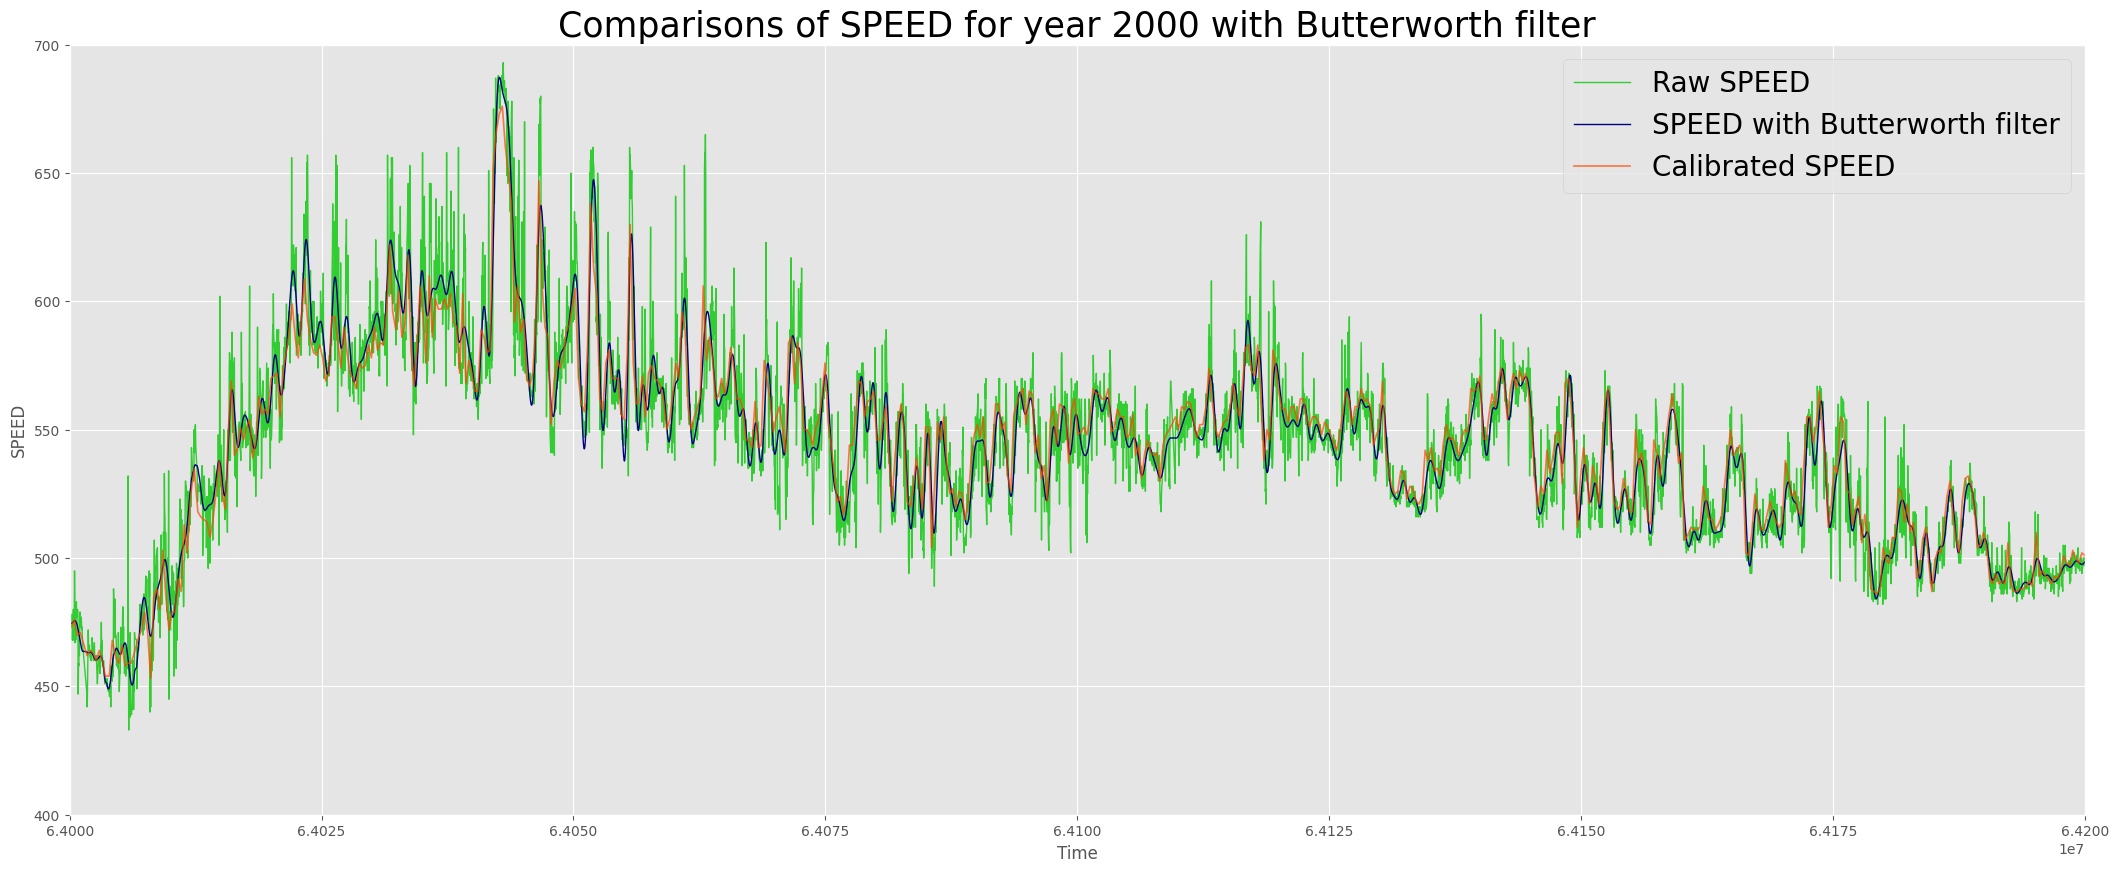

Numerador (z): [-1.05085549+0.j         -1.04035034+0.0304621j  -1.04035034-0.0304621j
 -1.01396097+0.04778173j -1.01396097-0.04778173j -0.98351933+0.04595199j
 -0.98351933-0.04595199j -0.96061121+0.02749879j -0.96061121-0.02749879j
 -0.95226082+0.j        ]
Denominador (p): [0.95449358+0.17929537j 0.95449358-0.17929537j 0.9055782 +0.15345557j
 0.9055782 -0.15345557j 0.86775046+0.11669561j 0.86775046-0.11669561j
 0.84219032+0.07271707j 0.84219032-0.07271707j 0.82934651+0.02467459j
 0.82934651-0.02467459j]
Ganancia:  3.029186094676115e-11


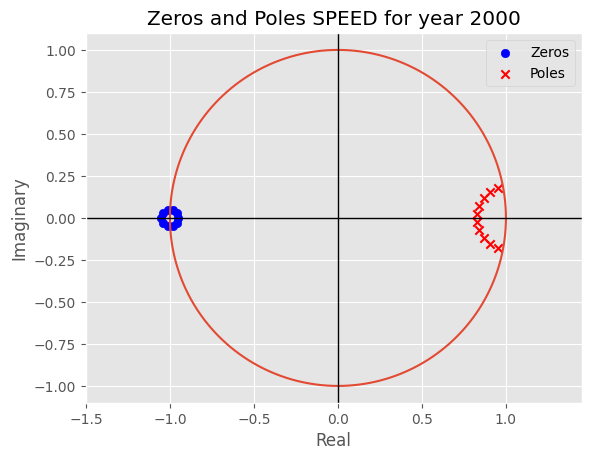

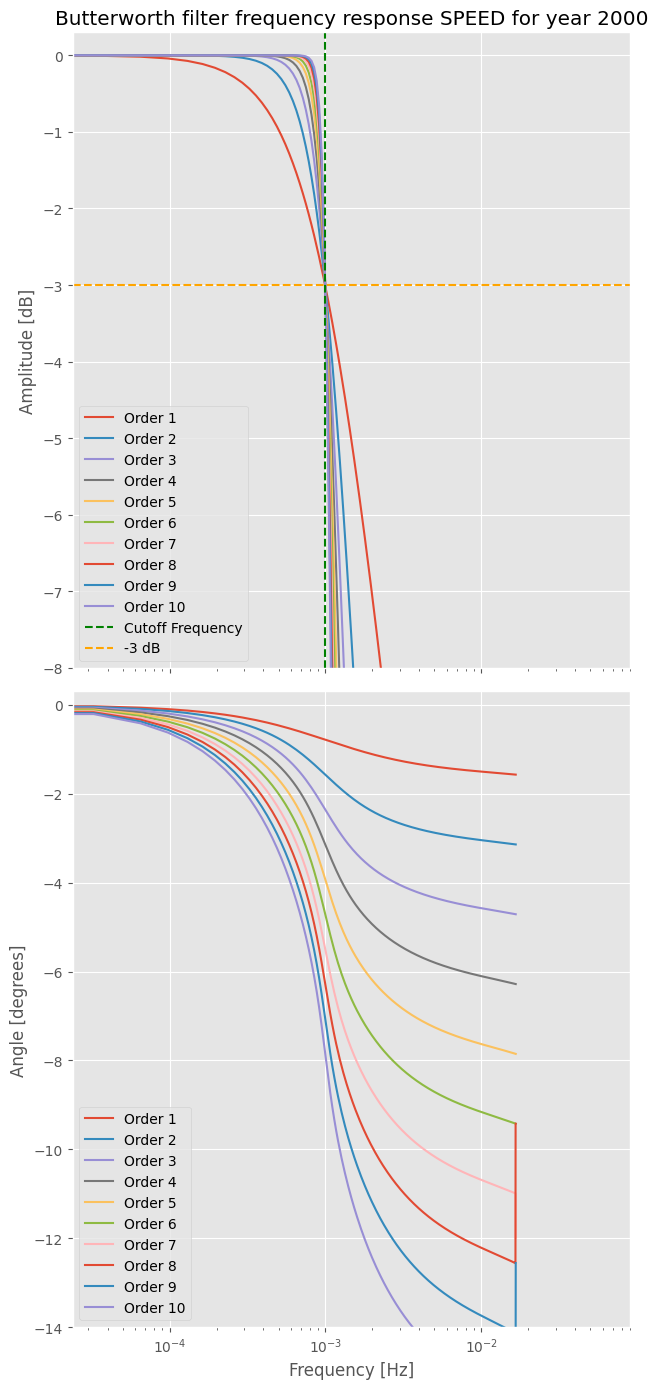

In [25]:
#Butterworth filter SPEED 2003
butterworth_filter(2000, "SPEED", 0.001) #year, column, cutcutoff frequency 0.009

Nyquist:  0.016666666666666666
Wn:  0.060000000000000005
Frecuencia de corte (rad/sec):  0.006283185307179587
Numerador (b): [3.11484549e-11 3.11484549e-10 1.40168047e-09 3.73781459e-09
 6.54117554e-09 7.84941064e-09 6.54117554e-09 3.73781459e-09
 1.40168047e-09 3.11484549e-10 3.11484549e-11]
Denominador (a): [   1.           -8.79517035   34.87498282  -82.09589685  127.04294386
 -135.03554288   99.83507904  -50.69181843   16.91672279   -3.35030545
    0.29900548]


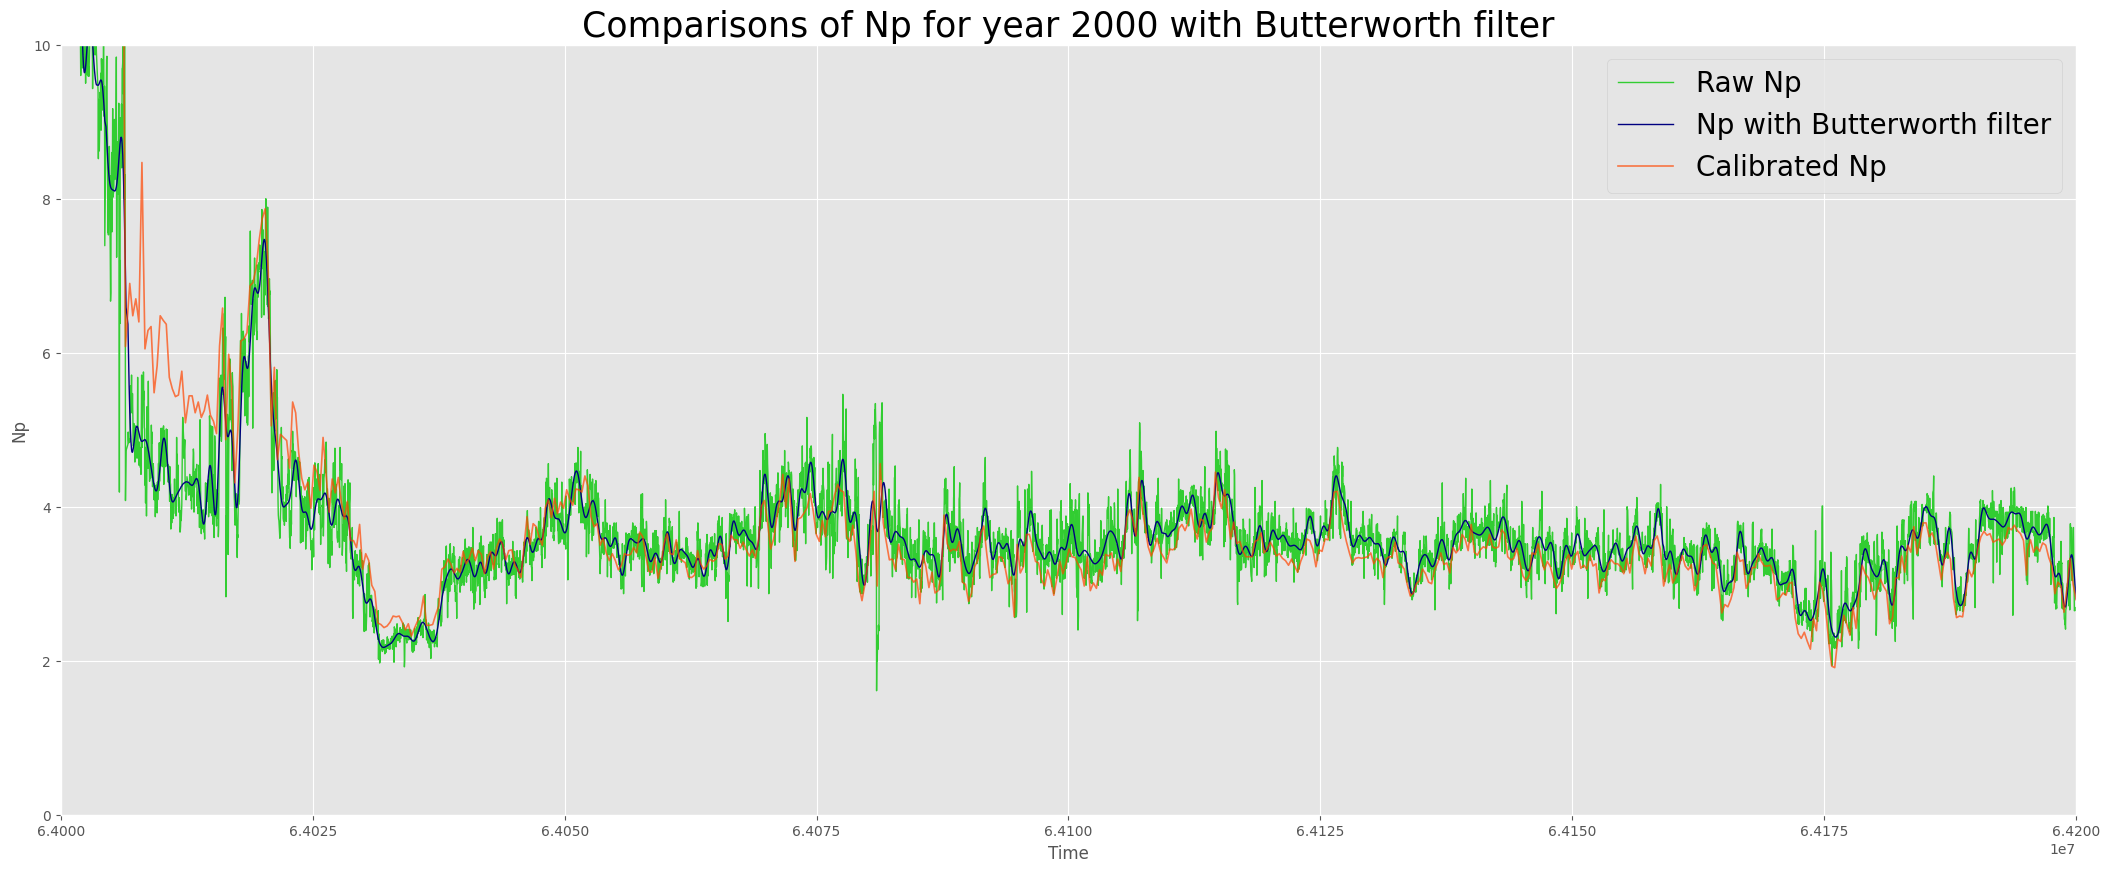

Numerador (z): [-1.05085549+0.j         -1.04035034+0.0304621j  -1.04035034-0.0304621j
 -1.01396097+0.04778173j -1.01396097-0.04778173j -0.98351933+0.04595199j
 -0.98351933-0.04595199j -0.96061121+0.02749879j -0.96061121-0.02749879j
 -0.95226082+0.j        ]
Denominador (p): [0.95449358+0.17929537j 0.95449358-0.17929537j 0.9055782 +0.15345557j
 0.9055782 -0.15345557j 0.86775046+0.11669561j 0.86775046-0.11669561j
 0.84219032+0.07271707j 0.84219032-0.07271707j 0.82934651+0.02467459j
 0.82934651-0.02467459j]
Ganancia:  3.029186094676115e-11


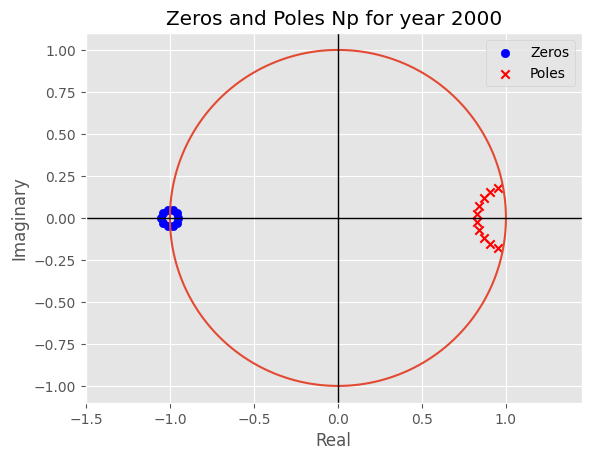

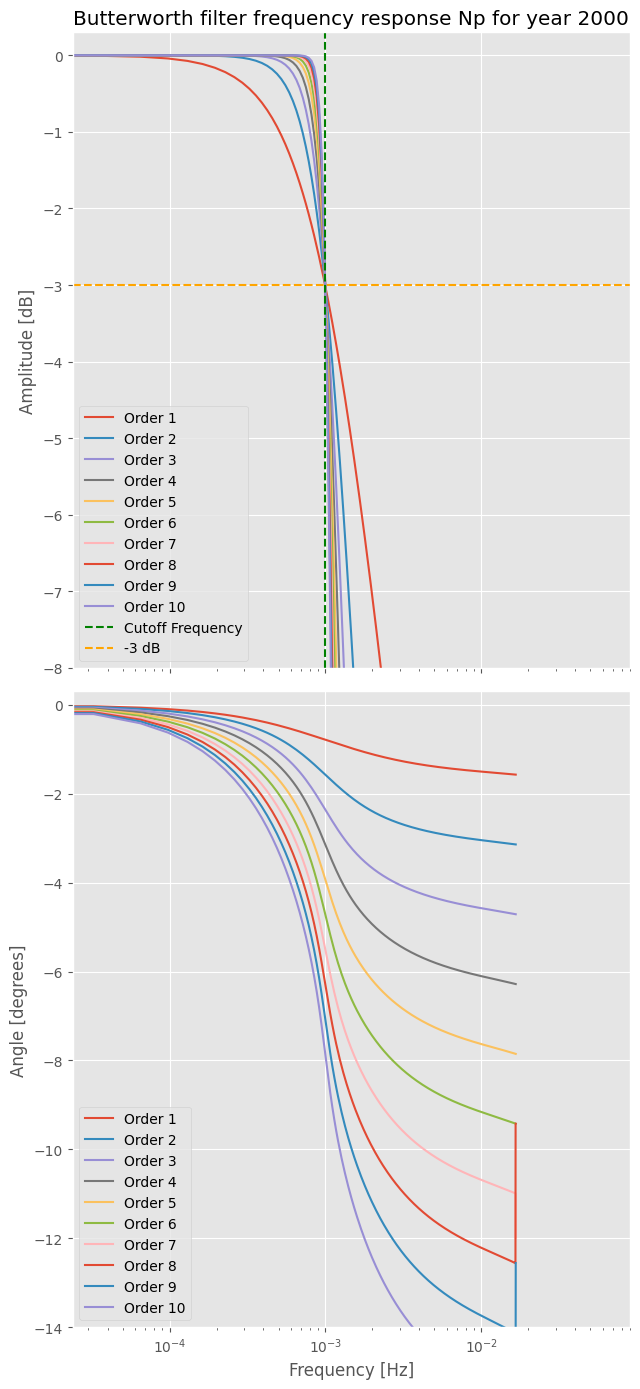

In [29]:
#Butterworth filter NP 2003
butterworth_filter(2000, "Np", 0.001) #year, column, cutcutoff frequency

Nyquist:  0.016666666666666666
Wn:  0.039
Frecuencia de corte (rad/sec):  0.0040840704496667305
Numerador (b): [5.09412416e-13 5.09412416e-12 2.29235587e-11 6.11294900e-11
 1.06976607e-10 1.28371929e-10 1.06976607e-10 6.11294900e-11
 2.29235587e-11 5.09412416e-12 5.09412416e-13]
Denominador (a): [   1.           -9.21681606   38.25600957  -94.1655547   152.21719477
 -168.84232146  130.14645114  -68.83604234   23.9084731    -4.9240341
    0.45664009]


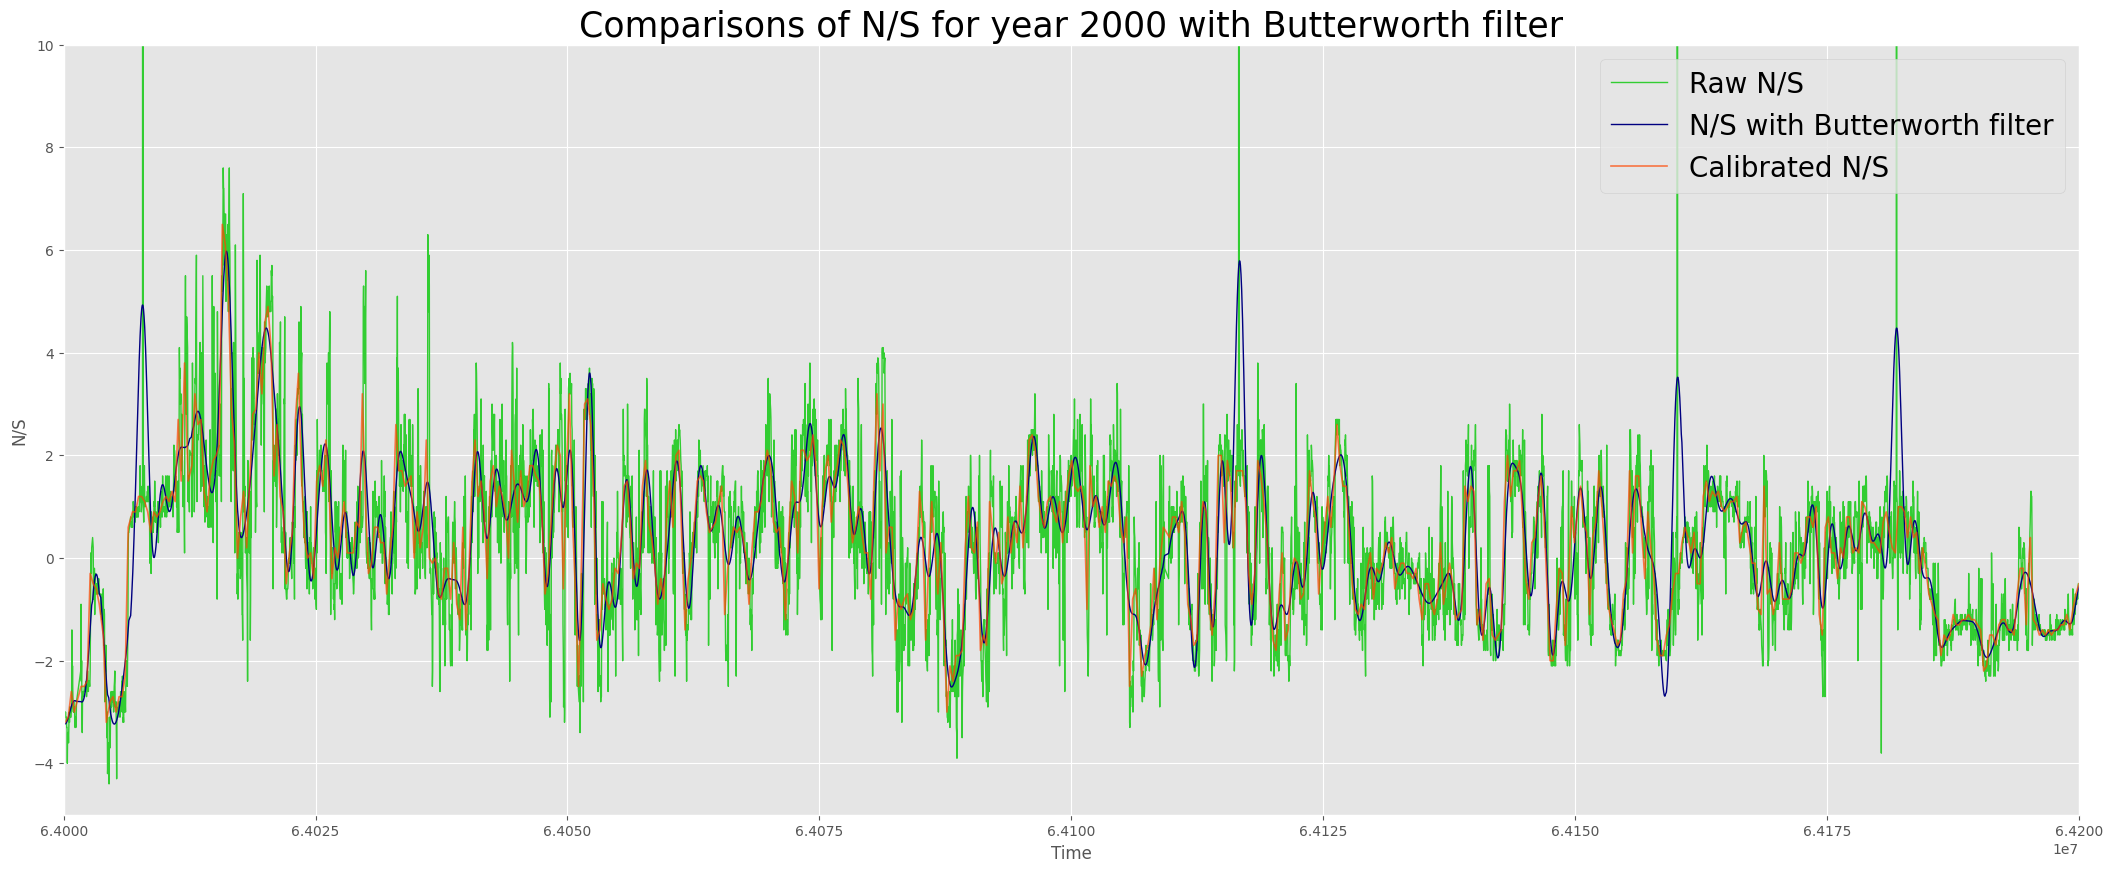

Numerador (z): [-1.0486659 +0.01614412j -1.0486659 -0.01614412j -1.02925286+0.04166079j
 -1.02925286-0.04166079j -0.99899397+0.05030124j -0.99899397-0.05030124j
 -0.9701264 +0.03974754j -0.9701264 -0.03974754j -0.95296087+0.01496287j
 -0.95296087-0.01496287j]
Denominador (p): [0.97392509+0.11830141j 0.97392509-0.11830141j 0.94041269+0.10305042j
 0.94041269-0.10305042j 0.91365678+0.07946364j 0.91365678-0.07946364j
 0.89515052+0.04996926j 0.89515052-0.04996926j 0.88575169+0.01702465j
 0.88575169-0.01702465j]
Ganancia:  5.033205488897951e-13


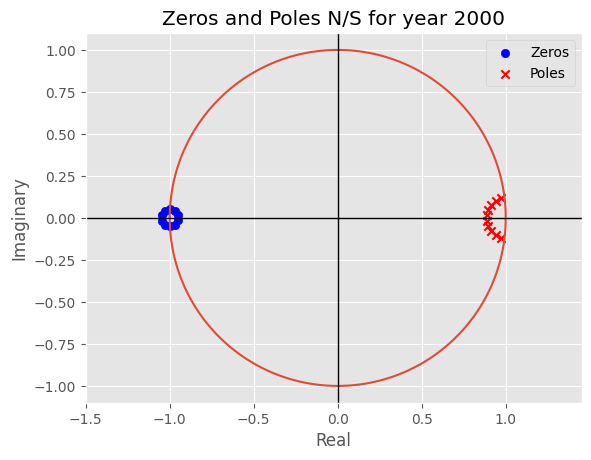

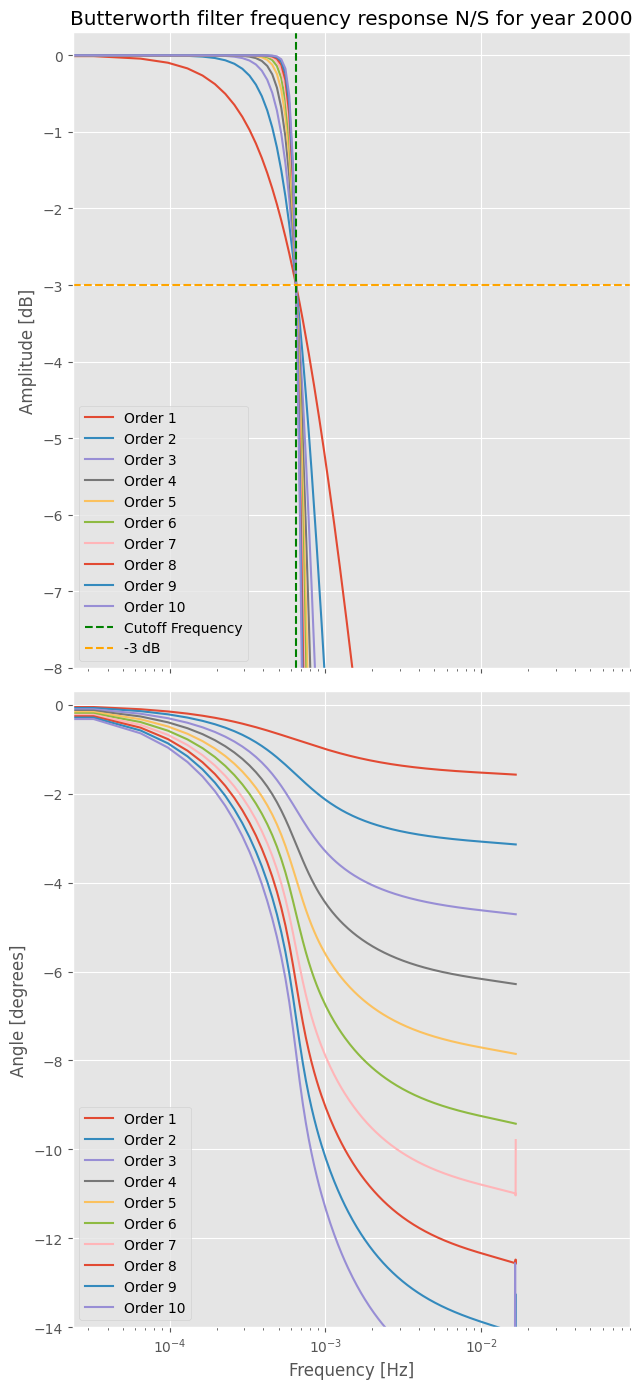

In [31]:
#Butterworth filter N/S 2003
butterworth_filter(2000, "N/S", 0.00065) #year, column, cutcutoff frequency

In [15]:
""" from scipy.signal import butter, filtfilt
import numpy as np
import pandas as pd

# Function to apply a Butterworth filter across a range of cutoff frequencies
def butterworth_diferent_frec(year, column, cutoff_freqs, order=10):
"""     """
    Applies a Butterworth filter to the specified column data at each cutoff frequency
    in cutoff_freqs, and returns a DataFrame with each filtered result as a column.
    
    Parameters:
    - year: The year of the dataset to filter.
    - column: The column name containing the data to be filtered.
    - cutoff_freqs: List or array of cutoff frequencies to test.
    - order: Order of the Butterworth filter (default is 4).
    
    Returns:
    - A DataFrame containing the filtered data for each cutoff frequency.
    """ """
    # Load the raw data for the specified year
    data_sheet = Raw_data[year]
    
    # Extract the time and data columns
    time_raw = data_sheet['Seconds']
    column_raw = data_sheet[column]

    # Create an empty DataFrame to store the filtered results
    filtered_data_df = pd.DataFrame({'Time (s)': time_raw})
    
    # Loop through each cutoff frequency and apply the Butterworth filter
    for cutoff_freq in cutoff_freqs:
        # Calculate the Nyquist frequency based on the sampling rate
        nyquist = 0.5 * (1 / (time_raw[1] - time_raw[0]))
        normal_cutoff = cutoff_freq / nyquist  # Normalize the cutoff frequency
        rad_sec_cutoff = 2*np.pi*cutoff_freq # cutoff frequency in rad/sec
        
        # Design the Butterworth filter
        b, a = butter(order, rad_sec_cutoff, btype='low', analog=True)#analogico
        #b, a = butter(order, normal_cutoff, btype='low', analog=False)#digital

        # Apply the Butterworth filter
        butter_filtered = filtfilt(b, a, column_raw)

        if cutoff_freq >= 0.10102:
            print("b: ", b)
            print("a: ", a)
        
        # Add the filtered data as a new column in the DataFrame
        #filtered_data_df[f'Filtered_{cutoff_freq:.5f}Hz'] = b[0]

    # Save the DataFrame as a CSV file
    #filename = f'butterworth_filtered_data_{year}_{column}.csv'
    #filtered_data_df.to_csv(filename, index=False)
    #print(f"Filtered data saved to {filename}")
    
    return filtered_data_df
    
# Define the range of cutoff frequencies and call the function
cutoff_frequencies = np.linspace(0.00001, 10, 100)  # Test frequencies from 0.00001 Hz to 0.5 Hz
error_results = butterworth_diferent_frec(2003, "SPEED", cutoff_frequencies)"""

' from scipy.signal import butter, filtfilt\nimport numpy as np\nimport pandas as pd\n\n# Function to apply a Butterworth filter across a range of cutoff frequencies\ndef butterworth_diferent_frec(year, column, cutoff_freqs, order=10):\n\n    Applies a Butterworth filter to the specified column data at each cutoff frequency\n    in cutoff_freqs, and returns a DataFrame with each filtered result as a column.\n    \n    Parameters:\n    - year: The year of the dataset to filter.\n    - column: The column name containing the data to be filtered.\n    - cutoff_freqs: List or array of cutoff frequencies to test.\n    - order: Order of the Butterworth filter (default is 4).\n    \n    Returns:\n    - A DataFrame containing the filtered data for each cutoff frequency.\n    \n    # Load the raw data for the specified year\n    data_sheet = Raw_data[year]\n    \n    # Extract the time and data columns\n    time_raw = data_sheet[\'Seconds\']\n    column_raw = data_sheet[column]\n\n    # Create a

In [16]:
from scipy.signal import butter, filtfilt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Función para aplicar el filtro de Butterworth y calcular errores
def butterworth_errors(year, column, cutoff_freqs, order=4):
    data_sheet = Raw_data[year]
    calibrated_sheet = Calibrated_data[year]
    
    # Columnas de tiempo en segundos
    time_raw = data_sheet['Seconds']
    time_calibrated = calibrated_sheet['Seconds']
    
    # Columna de datos crudos y calibrados
    column_raw = data_sheet[column]
    column_calibrated = calibrated_sheet[column]

    # Interpolar datos crudos y filtrados para que coincidan con los puntos de tiempo de los calibrados
    mae_list = []
    mse_list = []
    r2_list = []

    for cutoff_freq in cutoff_freqs:
        # Frecuencia de Nyquist y normalización de la frecuencia de corte
        nyquist = 0.5 * (1 / (time_raw[1] - time_raw[0]))
        normal_cutoff = cutoff_freq / nyquist
        
        # Aplicar filtro de Butterworth
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        butter_filtered = filtfilt(b, a, column_raw)
        
        # Interpolar los datos filtrados al tiempo calibrado (resampleo)
        butter_filtered_interp = np.interp(time_calibrated, time_raw, butter_filtered)
        
        # Calcular errores entre los datos interpolados y los datos calibrados
        mae = mean_absolute_error(column_calibrated, butter_filtered_interp)
        mse = mean_squared_error(column_calibrated, butter_filtered_interp)
        r2 = r2_score(column_calibrated, butter_filtered_interp)

        # Almacenar resultados
        mae_list.append(mae)
        mse_list.append(mse)
        r2_list.append(r2)
    
    # Crear DataFrame con los errores
    error_df = pd.DataFrame({
        'Cutoff Frequency (Hz)': cutoff_freqs,
        'MAE': mae_list,
        'MSE': mse_list,
        'R²': r2_list
    })

    # Encontrar la frecuencia de corte óptima para R², MAE y MSE
    best_r2_index = np.argmax(r2_list)  # Mayor R²
    best_mae_index = np.argmin(mae_list)  # Menor MAE
    best_mse_index = np.argmin(mse_list)  # Menor MSE

    # Imprimir las frecuencias de corte óptimas
    print(f"Frecuencia de corte con R² más cercano a 1: {cutoff_freqs[best_r2_index]} Hz (R² = {r2_list[best_r2_index]:.4f})")
    print(f"Frecuencia de corte con MAE mínimo: {cutoff_freqs[best_mae_index]} Hz (MAE = {mae_list[best_mae_index]:.4f})")
    print(f"Frecuencia de corte con MSE mínimo: {cutoff_freqs[best_mse_index]} Hz (MSE = {mse_list[best_mse_index]:.4f})")
    
    # Graficar los errores
    plt.figure(figsize=(12, 6))
    plt.plot(cutoff_freqs, mae_list, label="MAE", linewidth=2)
    plt.plot(cutoff_freqs, mse_list, label="MSE", linewidth=2)
    plt.plot(cutoff_freqs, r2_list, label="R²", linewidth=2)
    plt.xlabel("Cutoff frequency (Hz)")
    plt.ylabel("Error")
    #plt.ylim(0,2)
    plt.title(f"Errors for different cutoff frequencies {column} for year {year} with Butterworth filter", fontsize = 15)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.show()

    # Guardar la gráfica como archivo PNG
    filename_error = f'butterworth_errors_NS_{year}.png'
    plt.savefig(filename_error, format='png', dpi=300)
    print(f"Gráfica guardada como {filename_error}")
    
    return error_df

Frecuencia de corte con R² más cercano a 1: 0.000979090909090909 Hz (R² = 0.9910)
Frecuencia de corte con MAE mínimo: 0.000979090909090909 Hz (MAE = 5.0395)
Frecuencia de corte con MSE mínimo: 0.000979090909090909 Hz (MSE = 93.5797)


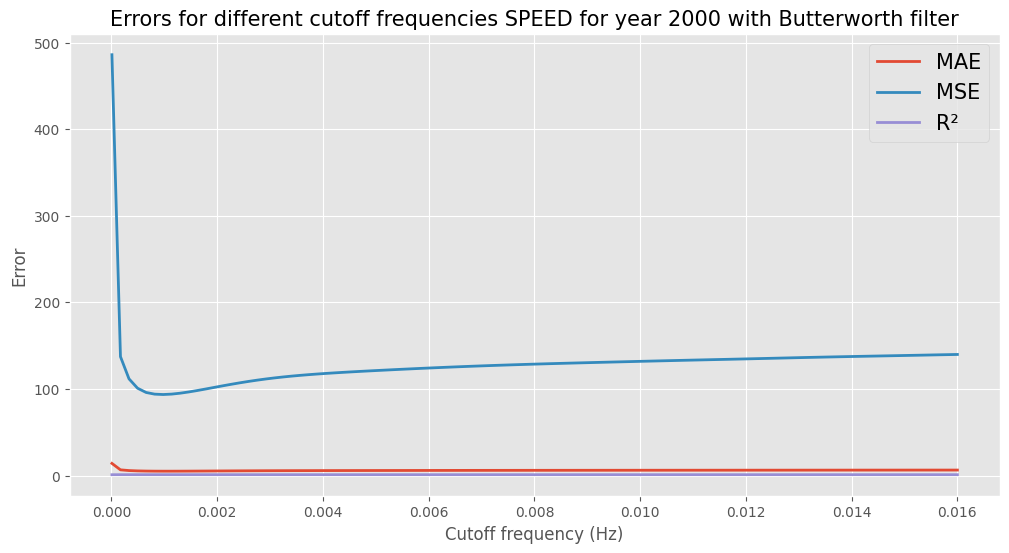

Gráfica guardada como butterworth_errors_NS_2000.png


<Figure size 640x480 with 0 Axes>

In [17]:
# 2003 SPEED
cutoff_frequencies = np.linspace(0.00001, 0.016, 100)  # Test frequencies from 0.00001 Hz to 0.016 Hz,
error_results = butterworth_errors(2000, "SPEED", cutoff_frequencies)

Frecuencia de corte con R² más cercano a 1: 0.000979090909090909 Hz (R² = 0.9624)
Frecuencia de corte con MAE mínimo: 0.000979090909090909 Hz (MAE = 0.5174)
Frecuencia de corte con MSE mínimo: 0.000979090909090909 Hz (MSE = 0.8583)


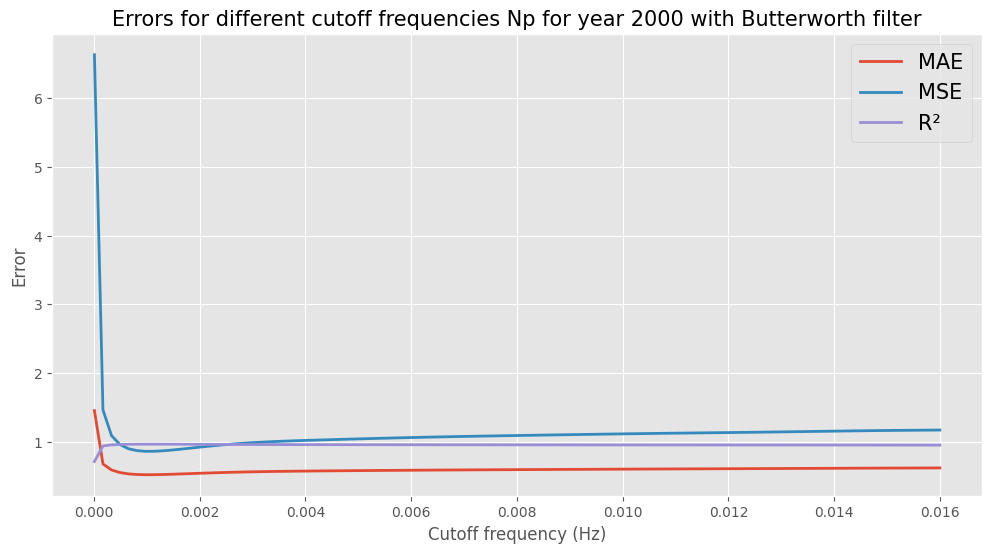

Gráfica guardada como butterworth_errors_NS_2000.png


<Figure size 640x480 with 0 Axes>

In [18]:
# 2003 Np
cutoff_frequencies = np.linspace(0.00001, 0.016, 100)  # Frecuencias de corte de prueba
error_results = butterworth_errors(2000, "Np", cutoff_frequencies)

Frecuencia de corte con R² más cercano a 1: 0.0006560606060606061 Hz (R² = 0.9139)
Frecuencia de corte con MAE mínimo: 0.000979090909090909 Hz (MAE = 0.2737)
Frecuencia de corte con MSE mínimo: 0.0006560606060606061 Hz (MSE = 0.2682)


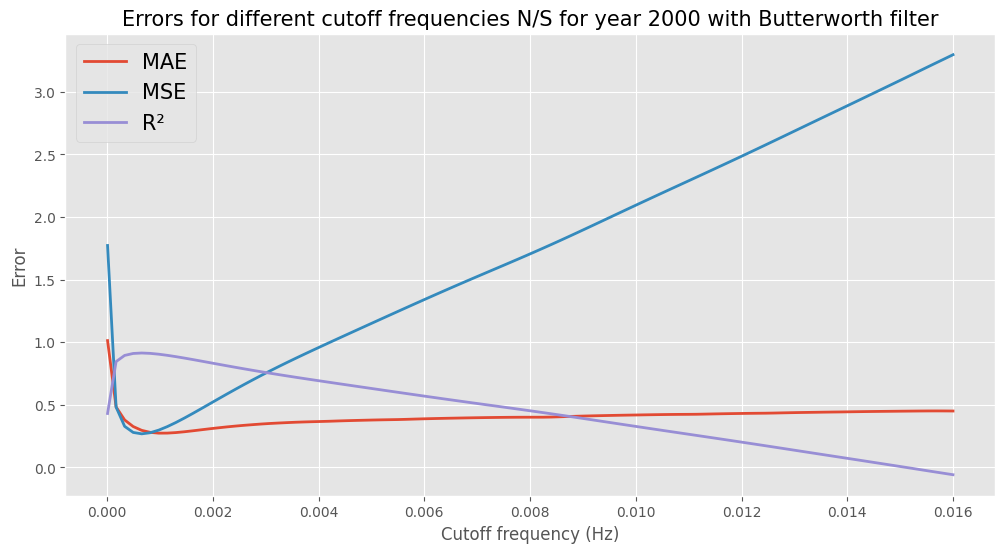

Gráfica guardada como butterworth_errors_NS_2000.png


<Figure size 640x480 with 0 Axes>

In [19]:
# 2003 N/S
cutoff_frequencies = np.linspace(0.00001, 0.016, 100)  # Test frequencies from 0.01 Hz to 0.5 Hz
error_results = butterworth_errors(2000, "N/S", cutoff_frequencies)